In [28]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
import pickle
spark = SparkSession.builder \
    .appName('Sistemas de Recomendación SVD') \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

sc = spark.sparkContext

In [20]:
# df_peliculas = spark.read.csv('../data/clean_data/peliculas_clean.csv', header=True, inferSchema=True, sep=";")
df_ratings = spark.read.parquet("../data/clean_data/ratings_clean/*")
df_movies = spark.read.parquet("../data/clean_data/movies_clean/*")

In [35]:
x = 9# número de columnas que quieres mostrar
df_movies.select(df_movies.columns[:x]).sort(F.asc("id")).show(6)


+---+--------------------+--------------------+------+------------+----------+-----------+-----+------------+
| id|               title|            overview|tmdbId|vote_average|vote_count|     genres|adult|release_date|
+---+--------------------+--------------------+------+------------+----------+-----------+-----+------------+
|  1|           Toy Story|Led by Woody, And...|   862|         7.7|    5415.0|16,35,10751|false|  1995-10-30|
|  2|             Jumanji|When siblings Jud...|  8844|         6.9|    2413.0|12,14,10751|false|  1995-12-15|
|  3|    Grumpier Old Men|A family wedding ...| 15602|         6.5|      92.0|   10749,35|false|  1995-12-22|
|  4|   Waiting to Exhale|Cheated on, mistr...| 31357|         6.1|      34.0|35,18,10749|false|  1995-12-22|
|  5|Father of the Bri...|Just when George ...| 11862|         5.7|     173.0|         35|false|  1995-02-10|
|  7|             Sabrina|An ugly duckling ...| 11860|         6.2|     141.0|   35,10749|false|  1995-12-15|
+---+-----

In [38]:
df_movies = df_movies.toPandas()

In [41]:
df_movies.to_csv("../data/clean_data/movies.csv", index = False)

In [37]:
df_movies.write.csv("../data/clean_data/movies_clean/peliculas.csv",header=True,mode="overwrite", sep=";")

In [3]:
ratings = df_ratings.select("userId", "movieId", "rating")

### Prueba de modelo ALS con Rank entre 20 y 26

In [ ]:
data = {"k":[],"rmse":[]}
(train, test) = ratings.randomSplit([0.8, 0.2],42)
for k in range(20,26):
    als = ALS(
        userCol="userId",
        itemCol="movieId",
        ratingCol="rating",
        nonnegative=True,
        implicitPrefs=False,  # Usa False para ratings explícitos
        coldStartStrategy="drop",  # Evita NaNs durante evaluación
        rank=k,         # Número de "factores latentes" (equivalente a k en SVD)
        maxIter=10,
        regParam=0.1
    )

    

    model = als.fit(train)
    
    predictions = model.transform(test)
    
    evaluator = RegressionEvaluator(
        metricName="rmse",
        labelCol="rating",
        predictionCol="prediction"
    )
    
    rmse = evaluator.evaluate(predictions)
    print(f"RMSE = {k}")
    data["k"].append(k)
    data["rmse"].append(rmse)

# model = als.fit(ratings)


In [16]:
rows = [{"k": k, "rmse": rmse} for k, rmse in zip(data["k"], data["rmse"])]

# Crear el DataFrame
dic = spark.createDataFrame(rows)

dic.show()

+---+------------------+
|  k|              rmse|
+---+------------------+
| 20|0.8217506025092896|
| 21|0.8224538287230314|
| 22|0.8209502503758933|
| 23|0.8215138093848042|
| 24|0.8223128517106421|
| 25|0.8226737041137376|
+---+------------------+



### Visualización de los Ranks junto con sus RMSE

/tmp/ipykernel_96/1894167424.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Comunidad Autónoma")


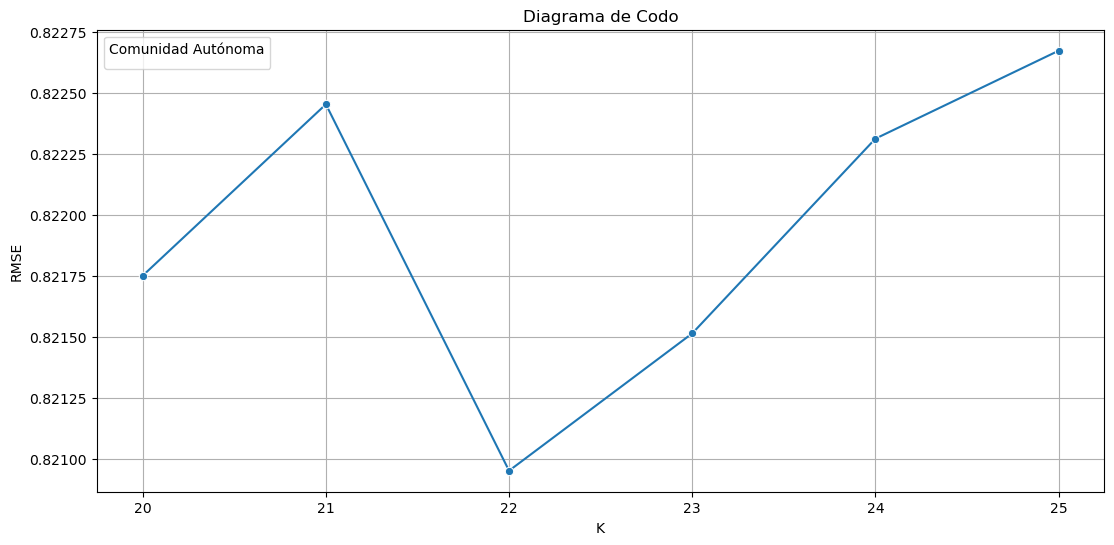

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
dd = dic.toPandas()
plt.figure(figsize=(13, 6))
sns.lineplot(data=dd, x="k", y="rmse", marker="o")
plt.title("Diagrama de Codo")
plt.xlabel("K")
plt.ylabel("RMSE")
plt.grid(True)
plt.show();

### Prueba de modelo ALS con Rank entre 18 y 22 y cambiando el parámetro alfa y las iteraciones máximas

In [ ]:
ranks = [18,19,20,21,22]
regParams = [0.05]
maxIters = [10,12,13, 15]

results = []
(train, test) = ratings.randomSplit([0.8, 0.2],42)
for rank in ranks:
    for reg in regParams:
        for iter in maxIters:
            als = ALS(
                userCol="userId", itemCol="movieId", ratingCol="rating",
                coldStartStrategy="drop", nonnegative=True,
                rank=rank, regParam=reg, maxIter=iter
            )
            model = als.fit(train)
            predictions = model.transform(test)
            evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
            rmse = evaluator.evaluate(predictions)
            results.append((rank, reg, iter, rmse))
            print(f"rank={rank}, reg={reg}, iter={iter} => RMSE={rmse:.4f}")


rank=18, reg=0.05, iter=10 => RMSE=0.8125
rank=18, reg=0.05, iter=12 => RMSE=0.8078
rank=18, reg=0.05, iter=13 => RMSE=0.8061
rank=18, reg=0.05, iter=15 => RMSE=0.8034
rank=19, reg=0.05, iter=10 => RMSE=0.8129
rank=19, reg=0.05, iter=12 => RMSE=0.8082
rank=19, reg=0.05, iter=13 => RMSE=0.8064
rank=19, reg=0.05, iter=15 => RMSE=0.8036
rank=20, reg=0.05, iter=10 => RMSE=0.8115
rank=20, reg=0.05, iter=12 => RMSE=0.8070
rank=20, reg=0.05, iter=13 => RMSE=0.8052
rank=20, reg=0.05, iter=15 => RMSE=0.8026
rank=21, reg=0.05, iter=10 => RMSE=0.8122
rank=21, reg=0.05, iter=12 => RMSE=0.8072
rank=21, reg=0.05, iter=13 => RMSE=0.8054
rank=21, reg=0.05, iter=15 => RMSE=0.8025


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/envs/recommender-env/lib/python3.9/socket.py", line 716, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


### Modelo final

In [4]:
(train, test) = ratings.randomSplit([0.8, 0.2],42)
als = ALS(
                userCol="userId", itemCol="movieId", ratingCol="rating",
                coldStartStrategy="drop", nonnegative=True,
                rank=19, regParam=0.05, maxIter=15
            )

model = als.fit(train)
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"""Modelo final con parámetros:
    Rank: 19,
    Alfa: 0.05,
    MaxIter: 15,
    RMSE: {rmse}""")

Modelo final con parámetros:
    Rank: 19,
    Alfa: 0.05,
    MaxIter: 15,
    RMSE: 0.8033495578489015


In [5]:
# userFactors: userId + features (vector)
user_factors = model.userFactors
item_factors = model.itemFactors

user_factors_pd = user_factors.toPandas()
item_factors_pd = item_factors.toPandas()

In [8]:
with open("models/user_factors.pkl", "wb") as f:
    pickle.dump(user_factors_pd, f)

with open("models/item_factors.pkl", "wb") as f:
    pickle.dump(item_factors_pd, f)

In [42]:
spark.stop()